# Trabajo Práctico 3: Detectando atributos de personas.

## Integrantes: Cravero, Ulises y Pautasso, L. Nicolás.
## Tema: CS:GO Professional Matches.

### Imports y configs

In [1]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# para descargar los datasets desde kaggle
import opendatasets as od

# para dividir el dataset
import os
import shutil
import pandas as pd
import random

### Descarga de datos

#### Descargamos el dataset desde Kaggle:

In [2]:
# descargamos el dataset correspondiente desde Kaggle
od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1.33G/1.33G [01:42<00:00, 14.0MB/s]


#### Fusionamos los datasets que nos serviran para identificar a que conjunto pertenece cada registro y si representa una imagen con barba o no

In [4]:
# cargamos ambos datasets
list_partition = pd.read_csv("./celeba-dataset/list_eval_partition.csv")
list_attribs = pd.read_csv("./celeba-dataset/list_attr_celeba.csv")

# merge en base a la columna 'image_id'
list_partition_and_attribs = pd.merge(list_partition, list_attribs[['image_id', 'No_Beard']], on='image_id', how='inner')

# formateamos
list_partition_and_attribs.columns = list_partition_and_attribs.columns.str.lower()

# convertimos de -1 y 1 a 0 y 1 (va a ser útil para armar el path despues)
list_partition_and_attribs['no_beard'] = np.where(list_partition_and_attribs['no_beard'] == 1, 1, 0)

list_partition_and_attribs.sample(3)

,image_id,partition,no_beard
164698,164699.jpg,1,1
5754,005755.jpg,0,1
37620,037621.jpg,0,1


#### Dividimos las imágenes en directorios dependiendo a que conjunto de datos pertenece

In [24]:
# ruta del directorio donde se descargaron las imágenes
directory = "./celeba-dataset/img_align_celeba/img_align_celeba"

# creamos las carpetas de destino
output_directory = "./partitions"
os.makedirs(output_directory, exist_ok=True)

# variables auxiliares para crear los directorios
partitions_names = ['train', 'validation', 'test']
group_names = ['yes_beard', 'no_beard']

# filtramos y movemos las imágenes a las carpetas correspondientes 
# (partitions_name[0] = train, partitions_name[1] = validation y partitions_name[2] = test)
# (groups_name[0] = yes_beard y groups_name[1] = no_beard)
for index, row in list_partition_and_attribs.iterrows():
    image_id = row['image_id']
    partition = row['partition']
    attribute = row['no_beard']
    source_path = os.path.join(directory, f"{image_id}")
    destination_path = os.path.join(output_directory, partitions_names[partition], group_names[attribute], f"{image_id}")
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    shutil.copyfile(source_path, destination_path)

### Análisis exploratorio sobre el conjunto de datos

#### Muestreo y caracteristicas de las imágenes:

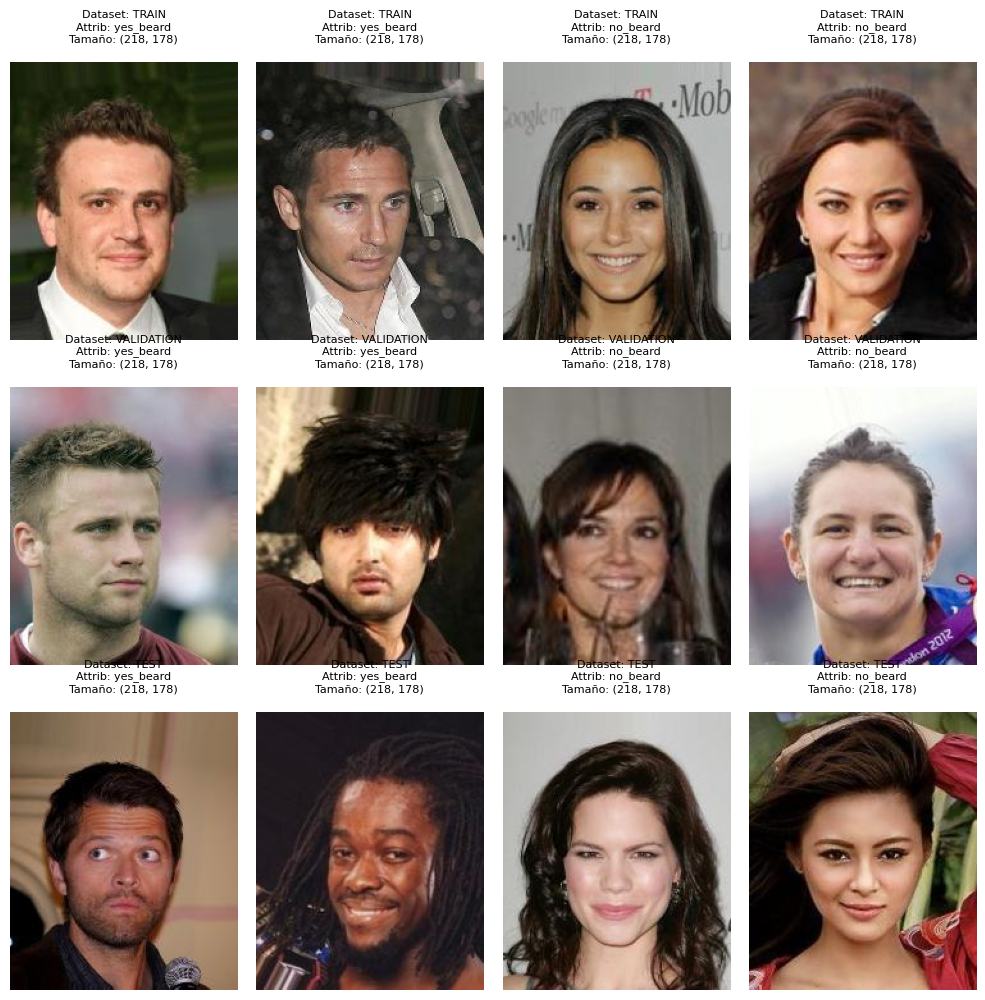

In [27]:
# Rutas de los directorios que contienen las imágenes
directorios = ['./partitions/train', './partitions/validation', './partitions/test']
nombre_set = ['train', 'validation', 'test']

# Mostrar una cuadrícula de 3x4
fig, axs = plt.subplots(3, 4, figsize=(10, 10))

# Iterar sobre los directorios
for i, directorio in enumerate(directorios):
    dir_yes_beard = os.path.join(directorio, group_names[0])
    dir_no_beard = os.path.join(directorio, group_names[1])
    # Elegir cuatro imágenes aleatorias dentro de los subdirectorios
    muestras_yes = random.sample(os.listdir(dir_yes_beard), 2)
    muestras_no = random.sample(os.listdir(dir_no_beard), 2)
    muestras = muestras_yes + muestras_no
    # Iterar sobre las muestras y mostrar las imágenes
    for j, muestra in enumerate(muestras):
        #nos fijamos a donde pertenece la muestra
        conjunto = group_names[0] if muestra in muestras_yes else group_names[1]
        ruta_imagen = os.path.join(directorio, conjunto, muestra)       
        # Leer la imagen y mostrarla
        img = plt.imread(ruta_imagen)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        # Obtener características de la imagen
        tamano = img.shape[:2]
        formato = muestra.split('.')[-1].upper()
        tipo = img.dtype
        axs[i, j].set_title(f"Dataset: {nombre_set[i].upper()}\nAttrib: {conjunto}\nTamaño: {tamano}\n", fontsize=8)
    
    
# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico con las imágenes
plt.show()

#### Cantidad de imagenes por conjunto, cantidad de imagenes por categoria/conjunto y distribución de la variable de salida ('no_beard') por conjunto:

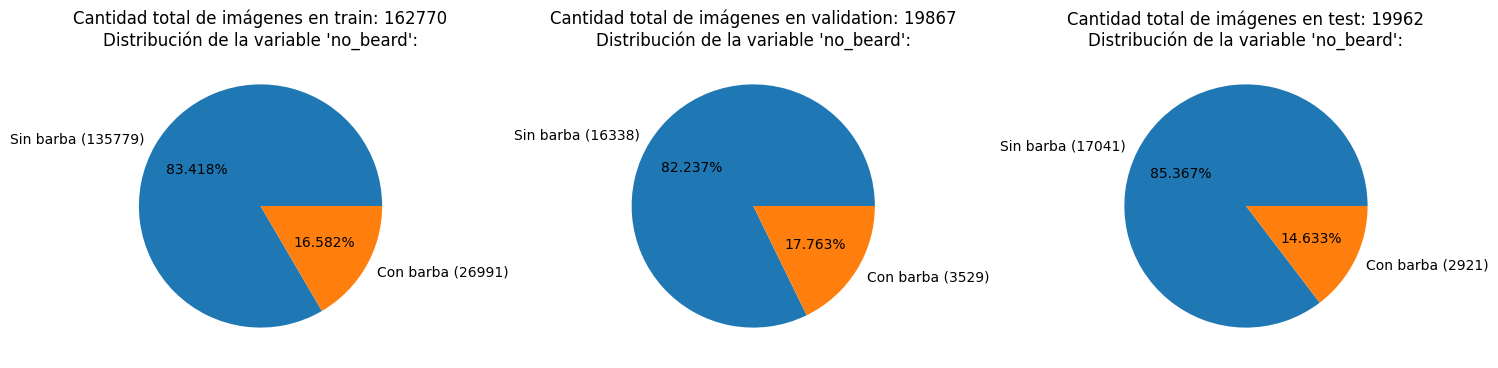

In [51]:
# 1 fila y 3 columnas

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
for index, _ in enumerate(partitions_names):
    ax = axs[index]
    partition_data = list_partition_and_attribs[list_partition_and_attribs['partition'] == index]
    no_beard = (partition_data['no_beard'] == 1).sum()
    yes_beard = (partition_data['no_beard'] == 0).sum()

    ax.pie([no_beard, yes_beard], labels=[f"Sin barba ({no_beard})", f"Con barba ({yes_beard})"], autopct='%1.3f%%')
    ax.set_title(f"Cantidad total de imágenes en {partitions_names[index]}: {no_beard + yes_beard}\nDistribución de la variable 'no_beard':")

plt.tight_layout()
plt.show()
    